<a href="https://colab.research.google.com/github/jqwhite/PhysBioCell/blob/main/diffusion_1d_and_FRAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion in 1-dimension and application to FRAP

This exercise was modified for use with Google Colaboratory.

In this tutorial, we will use numerical methods to estimate the probability distributions directly from the diffusion equation given by

\begin{align}
p(n,t) = p(n, t - \Delta t) + k \, \Delta t \, p(n-1, t - \Delta t) + k \, \Delta t \, p(n+1, t - \Delta t) - 2k \, \Delta t \, p(n,t - \Delta t). \tag{1}
\end{align}

This equation, called "the master equation," allows us to calculate the probability of the walker being at position $n$ at the time step $t$, given the probabilites at the previous time step $t - \Delta t$. $k$ is the hopping rate between neighboring positions, and $\Delta t$ is the time step used in the numerical calculation.

To impose hard boundary conditions at the edges so that no new material shows
up from the outside, we will modify the master equation at the boundaries to be

\begin{align}
p(0,t) &= p(0, t - \Delta t) + k \, \Delta t \, p(1, t - \Delta t) - k \, \Delta t \, p(0,t - \Delta t), \tag{2} \\
p(N,t) &= p(N, t - \Delta t) + k \, \Delta t \, p(N-1, t - \Delta t) - k \, \Delta t \, p(N,t - \Delta t), \tag{3}
\end{align}

where $N$ is the index of the rightmost position. To get a better sense for the effect of
diffusion on the probability distribution, we will examine two initial
conditions and similar to the numerical simulation of *E. coli* population
growth, we will program an updating scheme for the probability distribution
both in space and in time.

In [ ]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# for those who are interested in generating interactive plots
import panel as pn
pn.extension()

### Diffusion from a peaked center

In the first part of the tutorial, we will set the initial condition that all
of the molecules of interest are at the middle and observe the dynamics of the
distribution of its position over time.

To do that, we specify the number of boxes, the time increment $\Delta t$, the number of time steps and the hopping rate $k$ as our starting parameters. 
As we mentioned in class, we want to set $\Delta t$ such that $k \Delta t \ll 1$.

In [ ]:
# Number of boxes
n_boxes = 50

# Time increment (Delta t) in seconds
dt = 0.1

# Number of steps
n_steps = 100

# Hopping rate constant (k) in sec^-1
k = 1

We create a 2-dimensional `numpy` array to store the probabilities at different time points, set the initial probability distribution to be peaked at the centter and solve the master equation iteratively, by using the probabilities at the previous time step to evaluate those at the current time step.

In [ ]:
# Initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# Initial position
x0 = n_boxes // 2

p[x0, 0] = 1

# Boundary conditions
# @ n = 0 
# @ n = n_boxes-1

for t in range(1,n_steps):
    
    # Interior region
    for n in range(1,n_boxes-1):
        p[n,t] = p[n,t-1] + k*dt*p[n-1,t-1] + k*dt*p[n+1,t-1] - 2*k*dt*p[n,t-1]

    # Boundary cases
    p[0,t] = p[0,t] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # p[-1,t] chooses the last row and the t-th column
    p[-1, t] = p[-1, t-1] + k*dt*p[-2,t-1] - k*dt*p[-1, t-1]

To display the probabilities at different points in time, we will create subplots and vertically align them. Because the probability distribution
does not evolve particularly quickly in time, we will take every 10th time
step (1 second) and plot the output for the first 60 steps.

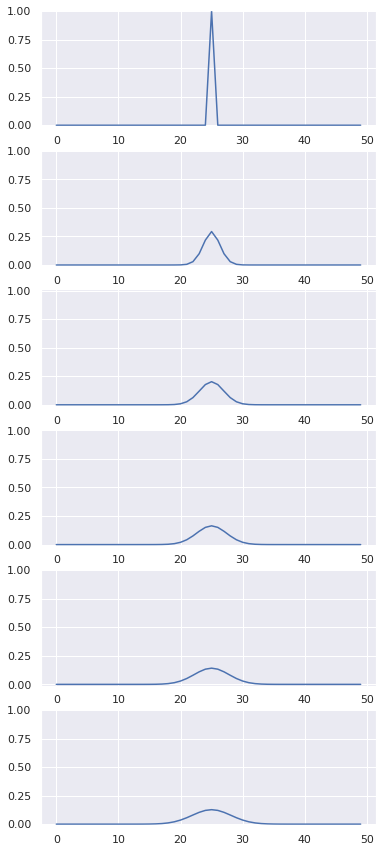

In [ ]:
# define 6 rows of subplots in one column
fig, ax = plt.subplots(6,1, figsize=(6,15))

# plot every 10th probability distribution, : takes the whole row (all of space)
for n in range(len(ax)):
  ax[n].plot(p[:,10*n])
  # fix the y-limit to be the same for all plots
  ax[n].set_ylim([-0.01,1.01])

As we can see, as time progresses, the probability distribution becomes wider 
and remains centered around the original position of the probability distribution.

We mentioned an analytical solution to the probability distribution that is peaked
at the center. Specifically, we saw that if I know the diffusion constant $D$
then my probability distribution in space and time $p \left( x, t \right)$ is 
given by
\begin{equation}
  p \left( x, t \right) = \frac{1}{\sqrt{4 \pi D t}} \exp \left( \frac{x^2}{4 D t} \right). \tag{4}
\end{equation}
We further note that $D$ relates to the hopping rate through the spatial step
size $a$ by
\begin{equation}
  D = k a^2. \tag{5}
\end{equation}
Since $a=1$ in our simulations, $D = k$. Eq. 4 describes a probability distribution that is peaked at $x=0$. To shift our peak to $x=x_0$, we
modify our Gaussian equation to be
\begin{equation}
  p \left( x, t \right) = \frac{1}{\sqrt{4 \pi D t}} \exp \left[ \frac{\left( x - x_0 \right) ^2}{4 D t} \right]. \tag{6}
\end{equation}
Let's plot this probability distribution below.

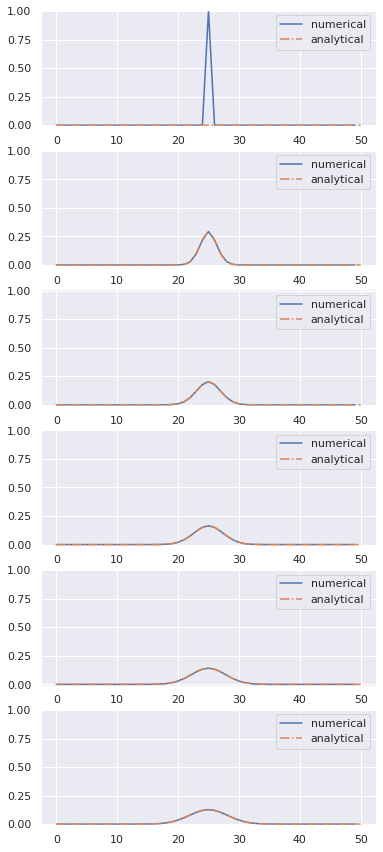

In [ ]:
# Create a list of x values that smoothes our Gaussian curve
x = np.linspace(0, n_boxes, 100)

# Create a time array for our Gaussian that's slightly padded so we don't divide by 0
times = np.arange(0, n_steps) * dt + 0.001

# Define our diffusion constant
D = k

# Create our Gaussian as a function of space and time
gaussian = np.zeros((len(x), len(times)))

# Loop through time to produce our Gaussian
for nt, time in enumerate(times):
  exponential = - (x - x0)**2 / (4 * D * time)
  denominator = np.sqrt(4 * np.pi * D * time)
  gaussian[:,nt] = np.exp(exponential) / denominator

# Plot both the Gaussian curve and our analytical solution.
fig, ax = plt.subplots(6,1, figsize=(6,15))

for n in range(len(ax)):
  ax[n].plot(p[:,10*n], label='numerical')
  ax[n].plot(x, gaussian[:,10*n], '-.', label='analytical')
  ax[n].legend(loc=1)
  ax[n].set_ylim([-0.01,1.01])

We can see a nice agreement between the analytical solution and the numerical
simulation.

(Optional) For the more computationally curious, we can use `panel` to turn
our plots into an interactive.

Column
    [0] FloatSlider(end=99, name='time slider', step=1)
    [1] ParamFunction(function)
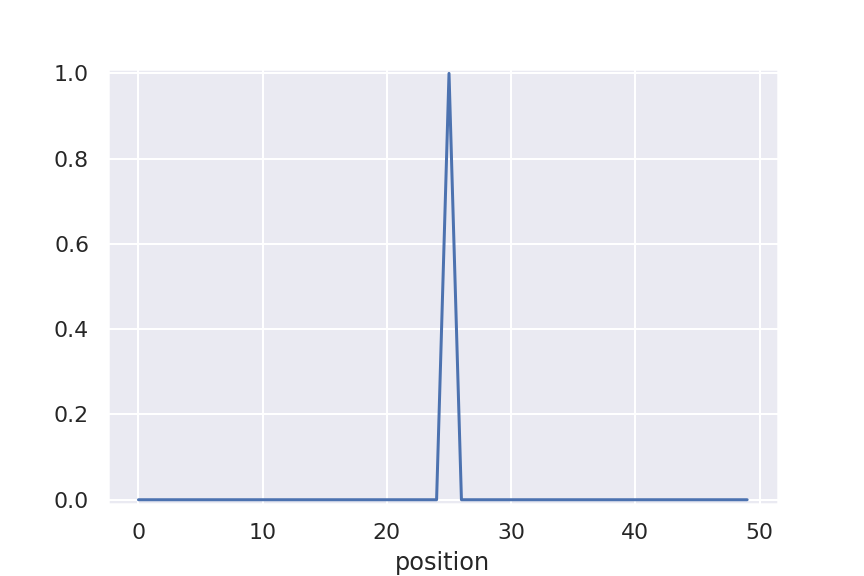

In [ ]:
# Interactive plot of the probability distribution over time

time_slider = pn.widgets.FloatSlider(
    name='time slider',
    start=0,
    end=n_steps-1,
    step=1,
    value=0
)
@pn.depends(time_slider.param.value) # make a new plot when the parameters in frame_player change
def movie_player(frame):
    # Initialize plot
    fig, ax = plt.subplots(1,1) # Making one figure in our interactive plot
    # Generate plot of distribution
    ax.plot(p[:, frame])
    ax.set_xlabel('position')
    # Set height for all plots
    ax.set_ylim([-0.01, 1.01])
    plt.close(fig)
    return fig

pn.Column(time_slider,
          movie_player)

### Fluorescence Recovery After Photobleaching (FRAP)

Having developed the numerical method of integrating the master equation, let's consider its application to the problem of fluorescence recovery after photobleaching (FRAP). In FRAP experiments, the fluorescently labeled molecules initially have a uniform distribution. Applying high intensity light, the fluorescent molecules in the desired region get photobleached, meaning that they no longer fluoresce. Over time, the fluorescent molecules that were outside the photobleached region will diffuse into it, recovering the uniform fluorescence distribution. By estimating the timescale of fluorescence recovery, experimentalists can determine the diffusion constant of fluorescently labeled molecules.

In this part of the tutorial we will implement the 1-dimensional version of the FRAP experiment. We will initialize the probability distribution as zero in the middle region and uniform outside it. We will when observe the process of recovery as the gap gets "filled" with probability from the two flanking regions.

In [ ]:
# Number of time steps
n_steps = 1000

# Time increment in seconds
dt = 0.2

# Initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# ---------- FRAP initialization ----------
# Assign non-zero values
p[:,0] = 1

# Photobleaching
start = n_boxes // 4
end = 3*n_boxes // 4
p[start:end,0] = 0

# Normalization
p[:,0] = p[:,0] / np.sum(p[:,0])

# ------------------------------------------

# Boundary conditions
# @ n = 0 
# @ n = n_boxes-1

for t in range(n_steps - 1):
    
    # Interior region
    for n in range(1,n_boxes-1):
        p[n,t+1] = p[n,t] + k*dt*p[n-1,t] + k*dt*p[n+1,t]  \
                          - 2*k*dt*p[n,t]

    # Boundary cases
    p[0,t+1] = p[0,t] + k*dt*p[1,t] - k*dt*p[0,t]
    p[-1, t+1] = p[-1, t] + k*dt*p[-2,t] - k*dt*p[-1, t]

Now let's use the subplots to look at snapshots of the probability distribution.

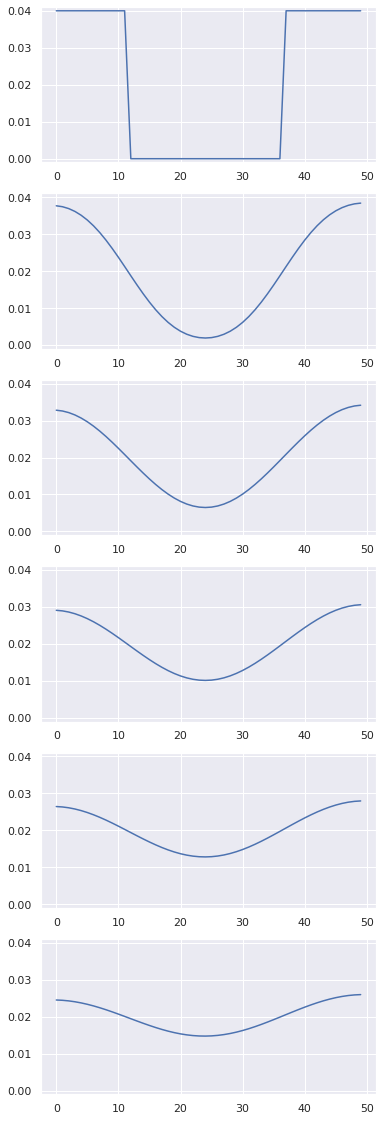

In [ ]:
# Generate 6 rows of figures
fig, ax = plt.subplots(6, 1, figsize=(6,20))

# Plot probability distribution every 20 seconds
for n in range(len(ax)):
  ax[n].plot(p[:,100*n])

  # Fix the y limits
  ax[n].set_ylim(-0.001, 0.041)

Here, we can see that the sharp edge between having particles and having none
quickly smooths out and the probability distriution starts to become more
uniform.

(Optional) We can once again generate an interactive to visualize this.

Column
    [0] FloatSlider(end=999, name='time slider', step=1)
    [1] ParamFunction(function)
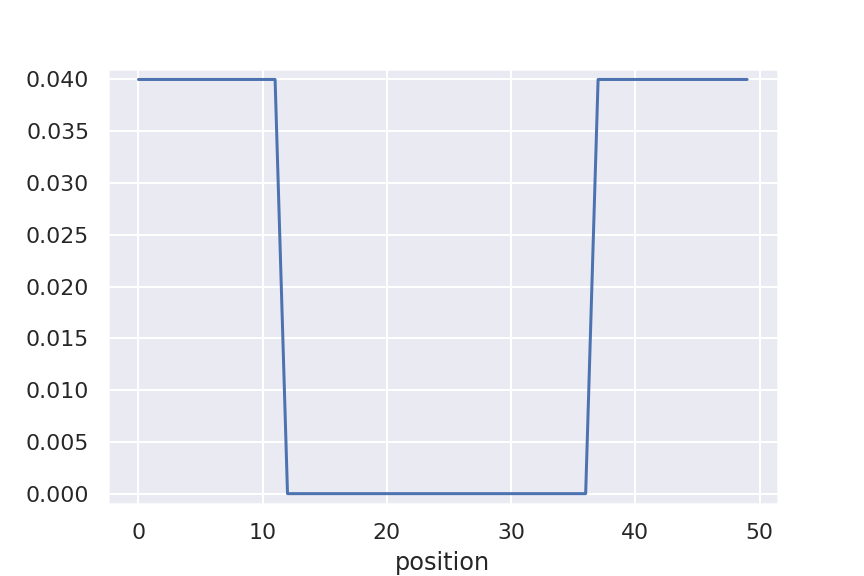

In [ ]:
# Interactive plot of the probability distribution over time

time_slider = pn.widgets.FloatSlider(
    name='time slider',
    start=0,
    end=n_steps-1,
    step=1,
    value=0
)
@pn.depends(time_slider.param.value) # make a new plot when the parameters in frame_player change
def slider(frame):
    # Initialize plot
    fig, ax = plt.subplots(1,1) # Making one figure in our interactive plot
    # Generate plot of distribution
    ax.plot(p[:, frame])
    ax.set_xlabel('position')
    ax.set_ylabel('height')
    # Set height for all plots
    ax.set_ylim([-0.001, 0.041])
    plt.close(fig)
    return fig

pn.Column(time_slider,
          slider)